In [12]:
import torch
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from typing import List
from pts.model.time_grad import TimeGradEstimator
from pts import Trainer
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from timefusion.utils import metrics

In [2]:
# Import dataset
train_data = pd.read_csv("../datasets/electricity/train.csv", index_col="date")
val_data = pd.read_csv("../datasets/electricity/val.csv", index_col="date")
test_data = pd.read_csv("../datasets/electricity/test.csv", index_col="date")

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

In [3]:
context_length = 24
prediction_length = 24

# Convert data into a glounts ListDataset
def get_dataset(df: pd.DataFrame, freq: str = "h", indices: List[int] = [-1]) -> ListDataset:
    return ListDataset(
        [
            {
                "start": df.index[0],
                "target": df.values[:i].T,
            }
            for i in indices
        ],
        freq=freq,
        one_dim_target=False
    )

train_dataset = get_dataset(train_data)
val_dataset = get_dataset(val_data)
test_dataset = get_dataset(test_data, indices=list(range(test_data.shape[0], test_data.shape[0] - 14*prediction_length, -prediction_length)))


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = TimeGradEstimator(
    target_dim=train_data.shape[1],
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=1280,
    freq="h",
    num_layers=3,
    num_cells=40,
    dropout_rate=0.1,
    residual_layers=16,
    scaling=True,
    diff_steps=100,
    beta_schedule="quad",
    trainer=Trainer(
        device=device,
        learning_rate=1e-3,
        clip_gradient=1e2
    )
)

In [5]:
# Train the model
predictor = estimator.train(training_data=train_dataset,num_workers=3)

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)


  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(t

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Tim

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(t

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a futu

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a futu

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Tim

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(t

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Tim

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is d

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a fu

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(t

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(t

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:07<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a futu

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Tim

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Tim

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprec

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a futu

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(t

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(t

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a futu

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(t

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a futu

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(t

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a futu

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(t

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Tim

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Tim

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if i

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is d

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(t

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Tim

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprec

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

  0%|          | 0/49 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14f9ce9eb6d0>
Traceback (most recent call last):
  File "/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in:     /rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWar

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Tim

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if i

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument

  0%|          | 0/49 [00:00<?, ?it/s]

/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/rds/general/user/ejh19/home/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a

In [19]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset,
    predictor=predictor,
    num_samples=128
)

In [20]:
samples = list(forecast_it)
realisations = list(ts_it)

samples = torch.tensor([sample.samples for sample in samples]).permute(0,1,3,2)
realisations_history = torch.tensor([real.values[-4*prediction_length:-prediction_length] for real in realisations]).permute(0,2,1)
realisations = torch.tensor([real.values[-prediction_length:] for real in realisations]).permute(0,2,1)


In [21]:
# MSE, MAE, MDAE

mean_predictions = samples.mean(axis=1)
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])

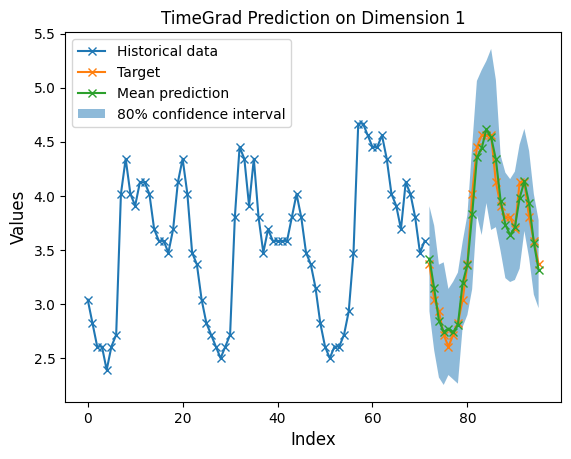

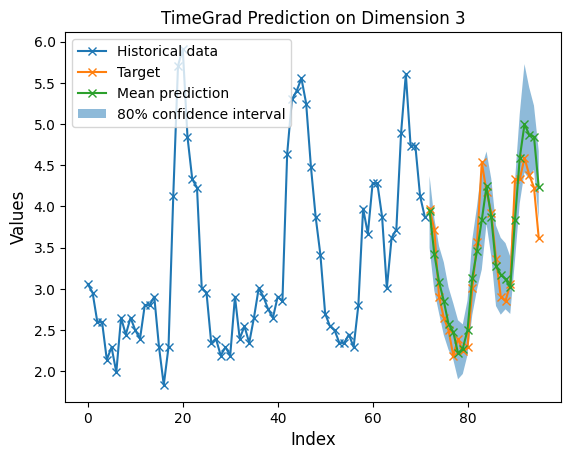

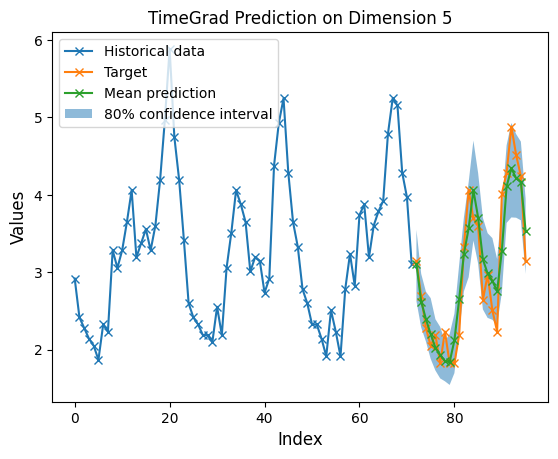

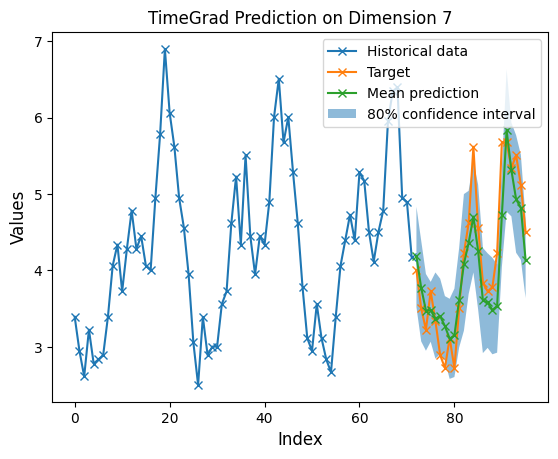

In [22]:
# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9

for ts in [1,3,5,7]:
    plt.figure()
    plt.title(f"TimeGrad Prediction on Dimension {ts}")
    plt.plot(list(range(3*prediction_length)),realisations_history[0,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),realisations[0,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),torch.mean(samples[0,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(3*prediction_length,4*prediction_length)), samples[0,int(confidence*samples.shape[1]),ts], samples[0,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    plt.legend(["Historical data","Target","Mean prediction","80% confidence interval"])
    plt.xlabel("Index",fontsize=12)
    plt.ylabel("Values",fontsize=12)
    plt.savefig(f"images/electricity_{ts}.png")

In [9]:
print(mse,mae,mdae,crps_sum,variogram_score)

0.1450096 0.25394517 0.16921616 11.946487039327621 0.05660575873425122


In [11]:
samples = list(forecast_it)
realistations = list(ts_it)

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


In [19]:
torch.tensor([sample.samples for sample in samples]).permute(0,1,3,2)

torch.Size([14, 128, 10, 24])

In [31]:
torch.tensor([real.values[-prediction_length:] for real in realistations]).permute(0,2,1)

torch.Size([14, 10, 24])

In [20]:
torch.tensor([real.samples for real in realistations]).permute(0,1,3,2)

AttributeError: 'DataFrame' object has no attribute 'samples'

In [7]:
samples = torch.tensor(np.array(list(forecast_it)))
realisations = torch.tensor(np.array(list(ts_it)))

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)